In [1]:
# first import all of the packages required in this entire project:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from glob import glob
import copy
import joblib
from tqdm import tqdm

tqdm.pandas()
import gc
from collections import defaultdict
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim import lr_scheduler
import cv2
import matplotlib

matplotlib.style.use('ggplot')
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold

Image.MAX_IMAGE_PIXELS = None
pd.set_option('display.float_format', '{:.2f}'.format)
import segmentation_models_pytorch as smp
from torchvision.models.resnet import Bottleneck, ResNet
from torchvision import transforms
from randstainna import RandStainNA
import pickle
import torchvision.transforms.functional as F

In [2]:
# load train_df for blood_vessel
train_df = pd.read_excel(r"\\fatherserverdw\Kevin\hubmap\unet++\bv_train_df.xlsx")
# train_df.drop('Unnamed: 0',inplace=True)
train_df
find_mean_std_dataset = False  # already found it, so False. Turn to true if you want to find std of mean of another dataset.

if find_mean_std_dataset:
    class HubmapDataset(Dataset):
        def __init__(self, df, transform=None):
            self.df = df
            self.directory = df["image_path"].tolist()
            self.transform = transform

        def __len__(self):
            return int(len(self.directory))

        def __getitem__(self, idx):
            path = self.directory[idx]
            image = cv2.imread(path, cv2.COLOR_BGR2RGB)
            if self.transform is not None:
                image = self.transform(image=image)['image']
            return image


    device = torch.device('cpu')
    num_workers = 0
    image_size = 384
    batch_size = 4

    augmentations = A.Compose([A.Resize(height=image_size, width=image_size),
                               A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
                               ToTensorV2()])

    unstain2stain_dataset = HubmapDataset(df=train_df, transform=augmentations)  # data loader
    image_loader = DataLoader(unstain2stain_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers,
                              pin_memory=True)

    images = next(iter(image_loader))
    print("Images have a tensor size of {}.".
          format(images.size()))

    # placeholders
    psum = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader, colour='red'):
        psum += inputs.sum(axis=[0, 2, 3])  # sum over axis 1
        psum_sq += (inputs ** 2).sum(axis=[0, 2, 3])  # sum over axis 1

    # pixel count
    count = len(train_df) * image_size * image_size

    # mean and std
    total_mean = psum / count
    total_var = (psum_sq / count) - (total_mean ** 2)
    total_std = torch.sqrt(total_var)

    # output
    print('mean: ' + str(total_mean))
    print('std:  ' + str(total_std))


# results:
# mean: tensor([0.6801, 0.4165, 0.6313])
# std:  tensor([0.1308, 0.2094, 0.1504])

In [3]:
class model_config:
    current_fold = 0
    seed = 42
    train_batch_size = 8
    valid_batch_size = 16
    epochs = 2  # ~24 minutes per 10 epoch for 1 fold
    learning_rate = 0.0014 # 0.001 for bs=16
    scheduler = "CosineAnnealingLR"
    num_training_samples = 5499
    T_max = int(
        num_training_samples / train_batch_size * epochs)  # number of iterations for a full cycle, need to change for different # of iterations. (iteration = batch size)
    weight_decay = 1e-6  # explore different weight decay (Adam optimizer)
    n_accumulate = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    iters_to_accumulate = max(1, 32 // train_batch_size)  # for scaling accumulated gradients
    eta_min = 1e-5
    dice_alpha = 0.5
    bce_alpha = 0.5
    model_save_directory = os.path.join(os.getcwd(), "model",
                                        "seresnext_attention_dropout_dilation_baseline")  #assuming os.getcwd is the current training script directory

# sets the seed of the entire notebook so results are the same every time we run for reproducibility. no randomness, everything is controlled.
def set_seed(seed=42):
    np.random.seed(seed)  #numpy specific random
    random.seed(seed)  # python specific random (also for albumentation augmentations)
    torch.manual_seed(seed)  # torch specific random
    torch.cuda.manual_seed(seed)  # cuda specific random
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # when deterministic = true, benchmark = False, otherwise might not be deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)  # set a fixed value for the hash seed, for hases like dictionary

set_seed(model_config.seed)

In [4]:
# for each fold
new_df_train = pd.read_excel(r"\\fatherserverdw\Kevin\hubmap\unet++_v2\train_fold{}.xlsx".format(model_config.current_fold))
new_df_train

,Unnamed: 0,id,real_id,source_wsi,dataset,fold,image_path,mask_path
0,0,5631a47d5b0c.tif,5631a47d5b0c,1,1,4,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
1,1,5631a47d5b0c_bot_right.tif,5631a47d5b0c,1,1,3,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
2,2,2fd7649afbc1.tif,2fd7649afbc1,1,1,1,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
3,3,88c95fb9fb14_bot_right.tif,88c95fb9fb14,1,1,2,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
4,4,dd690b7d9a47.tif,dd690b7d9a47,1,1,3,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
...,...,...,...,...,...,...,...,...
5494,5494,33361307e751_bot_left.tif,33361307e751,4,2,2,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
5495,5495,989936714cf5_top_left.tif,989936714cf5,4,2,4,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
5496,5496,dd4a8ba579c0.tif,dd4a8ba579c0,4,2,2,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
5497,5497,3b0d08f3e37a.tif,3b0d08f3e37a,4,2,3,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...


In [5]:
new_df_val = pd.read_excel(r"\\fatherserverdw\Kevin\hubmap\unet++_v2\val_fold{}.xlsx".format(model_config.current_fold))
new_df_val

,Unnamed: 0,id,real_id,source_wsi,dataset,fold,image_path,mask_path
0,0,2fd7649afbc1_top_right.tif,2fd7649afbc1,1,1,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
1,1,88c95fb9fb14.tif,88c95fb9fb14,1,1,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
2,2,dd690b7d9a47_top_right.tif,dd690b7d9a47,1,1,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
3,3,dd690b7d9a47_bot_right.tif,dd690b7d9a47,1,1,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
4,4,5566406c59ee_top_right.tif,5566406c59ee,1,1,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
...,...,...,...,...,...,...,...,...
1370,1370,2000408010ab_bot_left.tif,2000408010ab,4,2,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
1371,1371,989936714cf5.tif,989936714cf5,4,2,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
1372,1372,83dd35ad9daf.tif,83dd35ad9daf,4,2,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...
1373,1373,83dd35ad9daf_bot_left.tif,83dd35ad9daf,4,2,0,\\fatherserverdw\Kevin\hubmap\train_overlap\im...,\\fatherserverdw\Kevin\hubmap\train_overlap\ma...


In [12]:
# randstain pipeline, test if empty val_trnasforms is better or including just randstain is better
# train_transforms = transforms.Compose([transforms.ToPILImage(),
#                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#                                        # p changed from previous randstainna methods
#                                        transforms.RandomGrayscale(p=0.2),  # p changed from previous randstainna methods
#                                        RandStainNA(  # p changed from previous randstainna methods
#                                            yaml_file="randstainna_all.yaml",
#                                            std_hyper=-0.3,
#                                            probability=0.8,
#                                            distribution="normal",
#                                            is_train=True
#                                        )
#                                        ])
# val_transforms = transforms.Compose([RandStainNA(  # p changed from previous randstainna methods
#     yaml_file="randstainna_all.yaml",
#     std_hyper=-0.3,
#     probability=0.8,
#     distribution="normal",
#     is_train=True
# )])

# no randstain pipeline:
train_transforms = A.Compose([
    A.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1, p = 0.8),
    A.ToGray(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.Normalize(mean=(0.6801, 0.4165, 0.6313), std=(0.1308, 0.2094, 0.1504)),
    ToTensorV2() #V2 converts tensor to CHW automatically
])
val_transforms = A.Compose([
    # A.Normalize(mean=(0.6801, 0.4165, 0.6313), std=(0.1308, 0.2094, 0.1504)),
                            ToTensorV2()])

In [13]:
class TrainDataSet(Dataset):
    # initialize df, label, imagepath and transforms
    def __init__(self, df, transforms=None, label=True):
        self.df = df
        self.label = label
        self.imagepaths = df["image_path"].tolist()
        self.maskpaths = df["mask_path"].tolist()
        self.transforms = transforms

    # define length, which is simply length of all imagepaths
    def __len__(self):
        return len(self.df)

    # define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self, idx):
        image_path = self.imagepaths[idx]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        if self.label:
            mask_path = self.maskpaths[idx]
            mask = cv2.imread(mask_path, 0)
            mask = np.array(mask)
        if self.transforms is not None:  #albumentations vs torchvision difference:
            # torchvision (randstain):
            # image = self.transforms(image)
            # #apply horizontal and vertical flips to image and mask
            # if np.random.rand() < 0.5:
            #     image = np.flipud(image)  #vertical
            #     mask = np.flipud(mask)
            # if np.random.rand() < 0.5:
            #     image = np.fliplr(image)  #horizontal
            #     mask = np.fliplr(mask)
            # # Convert image and mask to tensors
            # image = np.ascontiguousarray(image)
            # image = np.transpose(image, (2, 0, 1))
            # mask = np.ascontiguousarray(mask)
            # image = torch.from_numpy(image.copy())  #.float()
            # mask = torch.from_numpy(mask.copy()).unsqueeze(0)  #.to(torch.uint8)
            #albumentation (no randstain):
            transformed = self.transforms(image=image,mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.unsqueeze(0)
            # image = torch.float 32, mask = torch.uint8
        # if self.transforms is None: # only for torchvision (randstain), for validation if no val_transforms
        #     image = np.transpose(image, (2, 0, 1))
        #     image = torch.from_numpy(image)
        #     mask = torch.from_numpy(mask).unsqueeze(0)
        return image, mask  # return tensors of image arrays, image should be 3x 512 x 512, mask 1 x 512 x 512 (need dummy dimension to match dimension)


# define dataloading function:
def load_dataset():
    model_df_train = new_df_train.reset_index(drop=True)
    model_df_val = new_df_val.reset_index(drop=True)
    train_dataset = TrainDataSet(df=model_df_train, transforms=train_transforms)  # image,mask pair
    # val_dataset = TrainDataSet(df=model_df_val, transforms=None) #no transforms for validation for randstain (torchvisions)
    val_dataset = TrainDataSet(df=model_df_val,
                               transforms=val_transforms)  #yes transforms for validation for not randstain (albumentations)
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=model_config.train_batch_size,
                                  # pin_memory= true allows faster data transport from cpu to gpu
                                  num_workers=0, pin_memory=True, shuffle=False)
    val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=model_config.valid_batch_size,
                                num_workers=0, pin_memory=True, shuffle=False)
    return train_dataloader, val_dataloader

In [14]:
train_dataloader, val_dataloader = load_dataset()
images, labels = next(iter(train_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))
images, labels = next(iter(val_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))

Images have a tensor size of torch.Size([8, 3, 512, 512]), and Labels have a tensor size of torch.Size([8, 1, 512, 512])
Images have a tensor size of torch.Size([16, 3, 512, 512]), and Labels have a tensor size of torch.Size([16, 1, 512, 512])


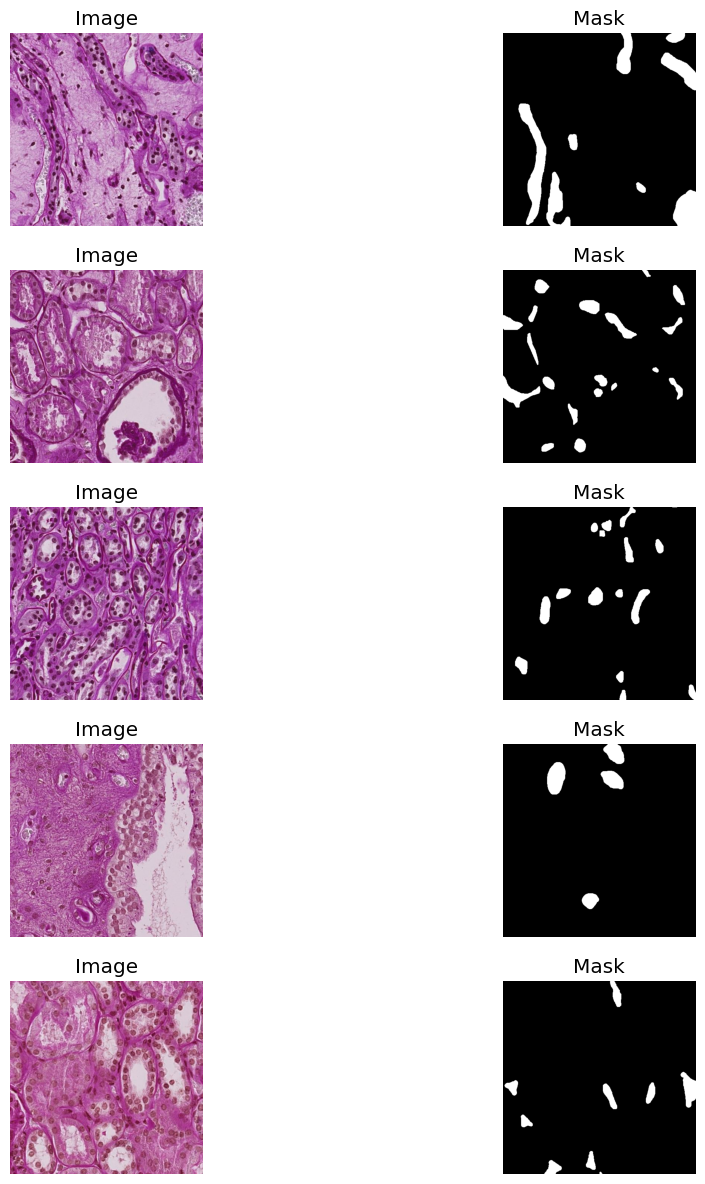

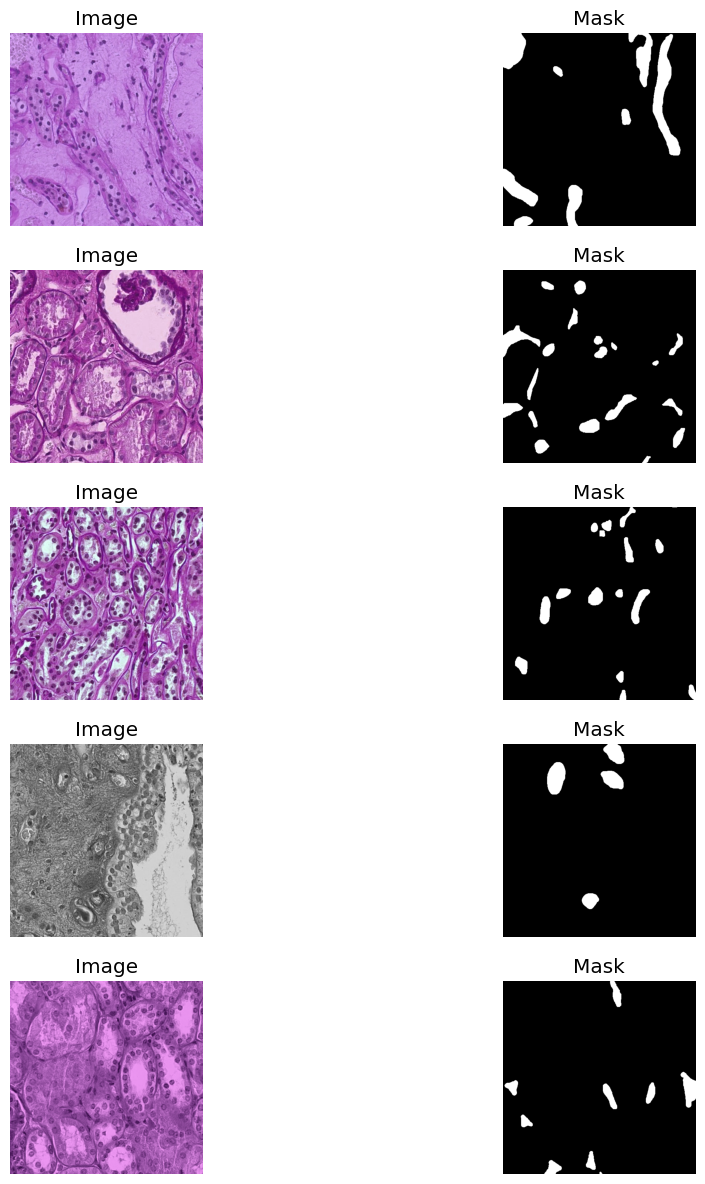

In [15]:
def visualize_images(dataset, num_images):
    random.seed(40)
    indices = random.sample(range(len(dataset)), num_images)

    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 12))
    fig.tight_layout()

    for i, ax_row in enumerate(axes):
        index = indices[i]
        image, mask = dataset[index]

        if dataset.transforms is None:
            ax_row[0].imshow(image)
        else:
            ax_row[0].imshow(image.permute(1,2,0)) #

        ax_row[0].set_title("Image")
        ax_row[0].axis("off")

        if dataset.transforms is None:
            ax_row[1].imshow(mask, cmap="gray")
        else:
            ax_row[1].imshow(mask.squeeze(0),cmap="gray")
        ax_row[1].set_title("Mask")
        ax_row[1].axis("off")

    plt.show()


visualize = True
if visualize:
    original_dataset = TrainDataSet(df=new_df_train, transforms=None)
    visualize_images(original_dataset, num_images=5)
    #%%
    train_dataset = TrainDataSet(df=new_df_train, transforms=train_transforms)
    visualize_images(train_dataset, num_images=5)

In [16]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    y_pred = y_pred > 0.5 #change this threshold maybe
    y_pred = y_pred * 1
    print("y_pred is {} and has length {} and 1st element has shape {}".format(y_pred,len(y_pred),y_pred[0].shape))
    pred_objects = len(np.unique(y_pred))
    print("true_objects is {} and pred_objects is {}".format(true_objects,pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    return iou[1:,1:]
    # return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    t = 0.6 # competition iou threshold = 0.6
    tps, fps, fns = 0, 0, 0
    for iou in ious:
        tp, fp, fn = precision_at(t, iou)
        tps += tp
        fps += fp
        fns += fn

    p = tps / (tps + fps + fns)
    prec.append(p)

    if verbose:
        print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [17]:
# random.seed(12321)
# y_pred = []
# labels = []
# for i in range(8):
#     ind_y_pred = np.random.rand(512, 512)
#     ind_labels = np.random.randint(2, size=(512, 512))
#     y_pred.append(ind_y_pred)
#     labels.append(ind_labels)

In [18]:
# # y_pred = np.zeros((512,512),dtype=np.uint8)
# # labels = np.ones((512,512),dtype=np.uint8)
# iou_map(labels,y_pred,verbose=1)


In [19]:
def build_model():
    model = smp.UnetPlusPlus(encoder_name="se_resnext50_32x4d", encoder_weights=None, activation=None,
                                 in_channels=3, classes=1, decoder_attention_type="scse", decoder_use_batchnorm=True,
                                 aux_params={"classes": 1, "pooling": "max", "dropout": 0.5})
    model.to(model_config.device)  # model to gpu
    return model

# dice_loss_func = smp.losses.DiceLoss(mode='binary')
# bce_loss_func = smp.losses.SoftBCEWithLogitsLoss()
iou_loss_func = smp.losses.JaccardLoss(mode='binary')

def loss_func(y_pred, y_true):  #weighted avg of the two, maybe explore different weighting if possible?
    return iou_loss_func(y_pred, y_true)
    # return  model_config.dice_alpha* dice_loss_func(y_pred,y_true) + model_config.bce_alpha * bce_loss_func(y_pred,y_true)

In [20]:
def epoch_train(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()  # set mode to train
    dataset_size = 0  #initialize
    running_loss = 0.0  #initialize
    scaler = GradScaler()  # enable GradScaler
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train', colour='red')
    for idx, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)  # move tensor to gpu
        masks = masks.to(device, dtype=torch.float)  # move tensor to gpu
        batch_size = model_config.train_batch_size  # return batch size N.

        with autocast(enabled=True, dtype=torch.float16):  # enable autocast for forward pass
            y_pred, _ = model(images)  # run this if aux_params (dropout, maxpool, attention)
            # y_pred = model(images) # forward pass, get y_pred from input
            # print(y_pred[0].dtype)
            # print(masks[0].dtype)
            # print(np.unique(masks[0].cpu().numpy(), return_counts=True))
            loss = loss_func(y_pred, masks)  # compute losses from y_pred
            loss = loss / model_config.iters_to_accumulate  # need to normalize since accumulating gradients
        scaler.scale(loss).backward()  # accumulates the scaled gradients

        if (idx + 1) % model_config.iters_to_accumulate == 0:  # scale updates should only happen at batch granularity
            scaler.step(optimizer)
            scaler.update()  # update scale for next iteration
            optimizer.zero_grad()  # zero the accumulated scaled gradients
            scheduler.step()  # change lr,make sure to call this after scaler.step

        running_loss += (loss.item() * batch_size)  # update current running loss for all images in batch
        dataset_size += batch_size  # update current datasize

        epoch_loss = running_loss / dataset_size  # get current epoch average loss
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}')

    torch.cuda.empty_cache()  #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss  #return loss for this epoch


@torch.no_grad()  # disable gradient calc for validation
def epoch_valid(model, dataloader, device, epoch):
    model.eval()  # set mode to eval
    dataset_size = 0  #initialize
    running_loss = 0.0  #initialize
    valid_ap_history = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Validation', colour='red')
    for idx, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        y_pred, _ = model(images)  # run this if aux_params (dropout, maxpool, attention)
        # y_pred = model(images)
        loss = loss_func(y_pred, masks)
        running_loss += (loss.item() * model_config.valid_batch_size)  #update current running loss
        dataset_size += model_config.valid_batch_size  #update current datasize
        epoch_loss = running_loss / dataset_size  #divide epoch loss by current datasize

        y_pred = nn.Sigmoid()(
            y_pred)  #sigmoid for multi-class, smp loss function has sigmoid in it, but iou_map doesn't have sigmoid.
        # print(torch.max(torch.squeeze(y_pred[0])))
        # print(torch.min(torch.squeeze(y_pred[0])))
        # print(torch.mean(torch.squeeze(y_pred[0])))
        masks = masks.squeeze(0)
        valid_ap = iou_map(masks.cpu().numpy(), y_pred.cpu().numpy(), verbose=0)
        valid_ap_history.append(valid_ap)
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.3f}',
                         lr=f'{current_lr:0.4f}')
    valid_ap_history = np.mean(valid_ap_history, axis=0)
    torch.cuda.empty_cache()  #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss, valid_ap_history  #return loss and valid_score_history for this epoch


def run_training(model, optimizer, scheduler, device, num_epochs):
    start = time.time()  # measure time
    best_model_wts = copy.deepcopy(model.state_dict())  #deepcopy
    best_ap = 0  # initial best score
    best_epoch = -1  # initial best epoch
    history = defaultdict(list)  # history defaultdict to store relevant variables

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print("Current Epoch {} / Total Epoch {}".format(epoch, num_epochs))
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = epoch_train(model, optimizer, scheduler,
                                 dataloader=train_dataloader,
                                 device=model_config.device, epoch=epoch)
        valid_loss, valid_ap_history = epoch_valid(model, dataloader=val_dataloader,
                                                                        device=model_config.device,
                                                                        epoch=epoch)
        valid_ap = valid_ap_history
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(valid_loss)
        history['Valid AP'].append(valid_ap)

        print(f'Valid AP: {valid_ap:0.4f}')

        # if dice score improves, save the best model
        if valid_ap >= best_ap:
            print(f"Valid Score Improved ({valid_ap:0.4f} ---> {best_ap:0.4f})")
            best_ap = valid_ap
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = os.path.join(model_config.model_save_directory, f"best_epoch-{model_config.current_fold:02d}.pt")
            if not os.path.exists(model_config.model_save_directory):
                os.makedirs(model_config.model_save_directory)
            torch.save(model.state_dict(), PATH)  #current directory (on kaggle)
            print("Model Saved!")

        # save the most recent model
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = os.path.join(model_config.model_save_directory, f"latest_epoch-{model_config.current_fold:02d}.pt")
        if not os.path.exists(model_config.model_save_directory):
            os.makedirs(model_config.model_save_directory)
        torch.save(model.state_dict(), PATH)

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60))
    print("Best AP@ 0.6IOU: {:.4f}".format(best_ap))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [21]:
model = build_model()
optimizer = optim.Adam(model.parameters(),
                       lr=model_config.learning_rate,
                       weight_decay=model_config.weight_decay)  # default learning rate
if model_config == "CosineAnnealingLR":  # change to CosineAnnealingLR
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=model_config.T_max,
                                               eta_min=model_config.eta_min)
print(model)

UnetPlusPlus(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
# Run Training!
train_dataloader, valid_dataloader = load_dataset()
model = build_model()
optimizer = optim.Adam(model.parameters(),
                       lr=model_config.learning_rate,
                       weight_decay=model_config.weight_decay)  # default learning rate

if model_config.scheduler == "CosineAnnealingLR":  # change to CosineAnnealingLR
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                               T_max=model_config.T_max,
                                               eta_min=model_config.eta_min)
print("Training for Fold {}".format(model_config.current_fold))
model, history = run_training(model, optimizer, scheduler,
                              device=model_config.device,
                              num_epochs=model_config.epochs)
pkl_save_path = os.path.join(model_config.model_save_directory, 'history.pickle')
#save history:
with open(pkl_save_path, 'wb') as file:
    pickle.dump(history, file)
